# Analyzing ATP Tennis Tournament Data: Trends & Predictions

## By Stefan Cutovic

tennis_atp_3.csv contains the Association of Tennis Professionals dataset in tabular CSV format. Each row in the dataset represents a single ATP tennis match played between 2013 and 2023. The dataset encompasses over 25,000 matches and includes various attributes related to each match:

- **Tournament**: The name of the tennis tournament where the match was played
- **Date**: The date when the match took place
- **Series**: The series or level of the tournament (e.g., ATP250, ATP500, Masters 1000)
- **Court**: Indicates whether the match was played on an indoor or outdoor court
- **Surface**: The type of surface the court had (e.g., Hard, Clay, Grass)
- **Round**: The round of the match within the tournament (e.g., 1st Round, Quarterfinals, Semifinals, Final)
- **Best of**: The maximum number of sets in the match (e.g., 3 for most matches, 5 for Grand Slam matches)
- **Player_1**: The name of one of the players participating in the match
- **Player_2**: The name of the other player participating in the match
- **Winner**: Indicates which player won the match
- **Rank_1**: The ATP ranking of Player_1 at the time of the match
- **Rank_2**: The ATP ranking of Player_2 at the time of the match
- **Pts_1**: The ATP ranking points of Player_1 at the time of the match
- **Pts_2**: The ATP ranking points of Player_2 at the time of the match
- **Score**: The final score of the match, typically in a set-by-set format (e.g., "6-4 6-4")

Any match that resulted in a walkover or retirement was removed entirely from the dataset.

In [32]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats import chi2_contingency

In [33]:
def read_csv_file(file_path):
    """
    Reads a CSV file and returns a DataFrame.
    """
    # Read the CSV file into a DataFrame
    dataframe = pd.read_csv(file_path)
    return dataframe



#################### TESTS ####################
expected_columns = ['Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of',
                   'Player_1', 'Player_2', 'Winner', 'Rank_1', 'Rank_2', 'Pts_1', 'Pts_2',
                   'score']
file = read_csv_file('tennis_atp_3.csv')
actual_columns = file.columns.tolist()
assert actual_columns == expected_columns, \
    f"Expected columns: {expected_columns}, Actual columns: {actual_columns}"
assert len(file) == 25163

In [34]:
atp_tennis_data = read_csv_file("tennis_atp_3.csv")
atp_tennis_data

,Tournament,Date,Series,Court,Surface,Round,Best of,Player_1,Player_2,Winner,Rank_1,Rank_2,Pts_1,Pts_2,score
0,Brisbane International,12/31/2012,ATP250,Outdoor,Hard,1st Round,3,Mayer F.,Giraldo S.,Mayer F.,28,57,1215,778,6-4 6-4
1,Brisbane International,12/31/2012,ATP250,Outdoor,Hard,1st Round,3,Benneteau J.,Nieminen J.,Nieminen J.,35,41,1075,927,3-6 6-2 1-6
2,Brisbane International,12/31/2012,ATP250,Outdoor,Hard,1st Round,3,Nishikori K.,Matosevic M.,Nishikori K.,19,49,1830,845,7-5 6-2
3,Brisbane International,12/31/2012,ATP250,Outdoor,Hard,1st Round,3,Mitchell B.,Baghdatis M.,Baghdatis M.,326,36,137,1070,4-6 4-6
4,Brisbane International,1/1/2013,ATP250,Outdoor,Hard,1st Round,3,Istomin D.,Klizan M.,Istomin D.,43,30,897,1175,6-1 6-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25158,Miami Open,3/30/2023,Masters 1000,Outdoor,Hard,Quarterfinals,3,Cerundolo F.,Khachanov K.,Khachanov K.,31,16,1320,2505,3-6 2-6
25159,Miami Open,3/31/2023,Masters 1000,Outdoor,Hard,Quarterfinals,3,Alcaraz C.,Fritz T.,Alcaraz C.,1,10,7420,2975,6-4 6-2
25160,Miami Open,3/31/2023,Masters 1000,Outdoor,Hard,Semifinals,3,Khachanov K.,Medvedev D.,Medvedev D.,16,5,2505,4330,6-7 6-3 3-6
25161,Miami Open,4/1/2023,Masters 1000,Outdoor,Hard,Semifinals,3,Sinner J.,Alcaraz C.,Sinner J.,11,1,2925,7420,6-7 6-4 6-2


In [35]:
def analyze_player_ranking_at_tournament(player_name, tournament):
    """
    Analyzes the ranking of a player in the first round of each tournament.
    """
    # Loads dataset
    tennis_data = pd.read_csv("tennis_atp_3.csv")

    # Extracts only the year from 'Date' column
    years = []
    for date in tennis_data['Date']:
        year = date.split('/')[-1]
        years.append(year)
    tennis_data['Year'] = years

    # Filters matches for specified player and tournament
    tournament_matches = tennis_data[tennis_data['Tournament'] == tournament]
    
    player_in_match = (
        (tennis_data['Player_1'] == player_name) |
        (tennis_data['Player_2'] == player_name)
    )
    
    first_round_matches = tennis_data['Round'] == '1st Round'
    
    player_matches = tournament_matches.loc[player_in_match & first_round_matches]
    if player_matches.empty:
        return f"{player_name} has never participated in {tournament}.\n\n"
    
    player_ranks = []
    output = f"{player_name}'s rank at {tournament} every year:\n\n"

    # Iterates over each match
    for index, match in player_matches.iterrows():
        if match['Player_1'] == player_name:
            player_rank = match['Rank_1']
        else:
            player_rank = match['Rank_2']

        # Adds player's rank to list
        player_ranks.append(player_rank)
        output += f"In {match['Year']}, {player_name}'s rank was {player_rank}.\n"

    # Calculates mean and median of player's ranks
    mean_rank = round(sum(player_ranks) / len(player_ranks))
    median_rank = sorted(player_ranks)[len(player_ranks) // 2]

    # Calculates Interquartile Range for rank (IQR)
    q1 = pd.Series(player_ranks).quantile(0.25)
    q3 = pd.Series(player_ranks).quantile(0.75)
    iqr = q3 - q1

    output += "\n"
    output += f"Mean Rank: {mean_rank}\n"
    output += f"Median Rank: {median_rank}\n"
    output += f"IQR of Rank: {iqr}\n\n"
    
    return output




#################### TESTS ####################

def test_analyze_player_ranking_at_tournament():

    # Test Case 1: Player participated in specified tournament
    expected_output = (
    "Fognini F.'s rank at US Open every year:\n\n"
    "In 2013, Fognini F.'s rank was 18.\n"
    "In 2014, Fognini F.'s rank was 17.\n"
    "In 2015, Fognini F.'s rank was 32.\n"
    "In 2016, Fognini F.'s rank was 38.\n"
    "In 2017, Fognini F.'s rank was 26.\n"
    "In 2018, Fognini F.'s rank was 14.\n"
    "In 2019, Fognini F.'s rank was 11.\n"
    "In 2021, Fognini F.'s rank was 31.\n"
    "In 2022, Fognini F.'s rank was 60.\n\n"
    "Mean Rank: 27\n"
    "Median Rank: 26\n"
    "IQR of Rank: 15.0\n\n"
    )
    assert analyze_player_ranking_at_tournament("Fognini F.", "US Open") == expected_output

    # Test Case 2: Player has never participated in specified tournament
    expected_output = ("Federer R. has never participated in Heineken Open.\n\n")
    assert analyze_player_ranking_at_tournament("Federer R.", "Heineken Open") == expected_output

test_analyze_player_ranking_at_tournament()

In [36]:
print(analyze_player_ranking_at_tournament("Djokovic N.", "Wimbledon"))
print(analyze_player_ranking_at_tournament("Djokovic N.", "Australian Open"))
print(analyze_player_ranking_at_tournament("Djokovic N.", "US Open"))
print(analyze_player_ranking_at_tournament("Djokovic N.", "Chennai Open"))

Djokovic N.'s rank at Wimbledon every year:

In 2013, Djokovic N.'s rank was 1.
In 2014, Djokovic N.'s rank was 2.
In 2015, Djokovic N.'s rank was 1.
In 2016, Djokovic N.'s rank was 1.
In 2017, Djokovic N.'s rank was 4.
In 2018, Djokovic N.'s rank was 21.
In 2019, Djokovic N.'s rank was 1.
In 2021, Djokovic N.'s rank was 1.
In 2022, Djokovic N.'s rank was 3.

Mean Rank: 4
Median Rank: 1
IQR of Rank: 2.0


Djokovic N.'s rank at Australian Open every year:

In 2013, Djokovic N.'s rank was 1.
In 2014, Djokovic N.'s rank was 2.
In 2015, Djokovic N.'s rank was 1.
In 2016, Djokovic N.'s rank was 1.
In 2017, Djokovic N.'s rank was 2.
In 2018, Djokovic N.'s rank was 14.
In 2019, Djokovic N.'s rank was 1.
In 2020, Djokovic N.'s rank was 2.
In 2021, Djokovic N.'s rank was 1.
In 2023, Djokovic N.'s rank was 5.

Mean Rank: 3
Median Rank: 2
IQR of Rank: 1.0


Djokovic N.'s rank at US Open every year:

In 2013, Djokovic N.'s rank was 1.
In 2014, Djokovic N.'s rank was 1.
In 2015, Djokovic N.'s rank 

In [37]:
def match_analysis(player_name, tournament, year):
    """
    Analyzes a player's performance in a specified tennis tournament for a given year.
    """
    # Loads the dataset
    tennis_data = pd.read_csv("tennis_atp_3.csv")

    # Initializes counter for number of times player beat someone with better rank
    better_rank_wins = 0

    # Flag to track if any matches were found for player in specified tournament and year
    matches_found = False

    # Prints header for analysis
    output = f"{player_name}'s matches at {tournament} {year}\n\n"

    # Iterates over matches
    for index, match in tennis_data.iterrows():
        if (player_name in match['Player_1'] or player_name in match['Player_2']) and \
           str(year) in match['Date'] and match['Tournament'] == tournament:
            matches_found = True

            # Determines player's rank and opponent's rank
            if player_name in match['Player_1']:
                player_rank = match['Rank_1']
                opponent_rank = match['Rank_2']
                opponent_name = match['Player_2']
                
            else:
                player_rank = match['Rank_2']
                opponent_rank = match['Rank_1']
                opponent_name = match['Player_1']

            # Determines outcome of match
            if match['Winner'] == player_name:
                outcome = "def."
            else:
                outcome = "lost to"

            # Checks if player beat opponent with better rank
            if player_rank > opponent_rank and outcome == "def.":
                better_rank_wins += 1

            # Determines round played
            if 'Final' in match['Round']:
                round_played = 'Finals'
                
            elif 'Semifinal' in match['Round']:
                round_played = 'Semifinals'
                
            elif 'Quarterfinal' in match['Round']:
                round_played = 'Quarterfinals'
                
            else:
                round_played = match['Round'] # For rounds before Quarterfinals

            # Append match info to output
            output += (
                f"{round_played}: {player_name} ({player_rank}) "
                f"{outcome} {opponent_name} ({opponent_rank})\n"
            )
    if not matches_found:
        output += f"{player_name} did not participate in {tournament} in {year}.\n"

    output += (
        f"\n{player_name} beat an opponent with a better rank "
        f"{better_rank_wins} times throughout the course of the tournament.\n\n"
    )
    print("")
    print("")
    
    return output




#################### TESTS ####################
def test_match_analysis():
    # Test Case 1: Player participated in specified tournament
    expected_output = (
        "Fognini F.'s matches at US Open 2015\n\n"
        "1st Round: Fognini F. (32) def. Johnson S. (47)\n"
        "2nd Round: Fognini F. (32) def. Cuevas P. (40)\n"
        "3rd Round: Fognini F. (32) def. Nadal R. (8)\n"
        "4th Round: Fognini F. (32) lost to Lopez F. (19)\n\n"
        "Fognini F. beat an opponent with a better rank 1 times throughout the course of the tournament.\n\n"
    )
    assert match_analysis('Fognini F.', 'US Open', 2015) == expected_output
    
    # Test Case 2: Player has never participated in specified tournament and year
    expected_output = (
        "Federer R.'s matches at Wimbledon 2022\n\n"
        "Federer R. did not participate in Wimbledon in 2022.\n\n"
        "Federer R. beat an opponent with a better rank 0 times throughout the course of the tournament.\n\n"
    )
    assert match_analysis('Federer R.', 'Wimbledon', 2022) == expected_output
    
test_match_analysis()

In [38]:
print(match_analysis('Gasquet R.', 'Wimbledon', 2013))
print(match_analysis('Gasquet R.', 'Wimbledon', 2015))
print(match_analysis('Gasquet R.', 'Wimbledon', 2019))
print(match_analysis('Del Potro J.M.', 'Wimbledon', 2019))



Gasquet R.'s matches at Wimbledon 2013

1st Round: Gasquet R. (9) def. Granollers M. (41)
2nd Round: Gasquet R. (9) def. Soeda G. (129)
3rd Round: Gasquet R. (9) lost to Tomic B. (59)

Gasquet R. beat an opponent with a better rank 0 times throughout the course of the tournament.




Gasquet R.'s matches at Wimbledon 2015

1st Round: Gasquet R. (20) def. Saville L. (183)
2nd Round: Gasquet R. (20) def. De Schepper K. (163)
3rd Round: Gasquet R. (20) def. Dimitrov G. (11)
4th Round: Gasquet R. (20) def. Kyrgios N. (29)
Quarterfinals: Gasquet R. (20) def. Wawrinka S. (4)
Semifinals: Gasquet R. (20) lost to Djokovic N. (1)

Gasquet R. beat an opponent with a better rank 2 times throughout the course of the tournament.




Gasquet R.'s matches at Wimbledon 2019

1st Round: Gasquet R. (47) lost to Pouille L. (28)

Gasquet R. beat an opponent with a better rank 0 times throughout the course of the tournament.




Del Potro J.M.'s matches at Wimbledon 2019

Del Potro J.M. did not participat

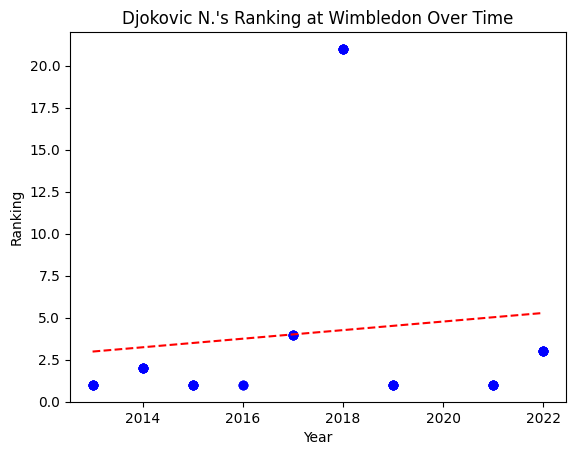

In [39]:
def plot_player_ranking_over_time(player_name, tournament):
    """
    Plots the ranking of a player at a specific tournament over time.
    Applies a regression model to determine ranking trajectory.
    """
    # Load dataset
    tennis_data = pd.read_csv("tennis_atp_3.csv")

    # Convert 'Date' column to datetime format
    tennis_data['Date'] = pd.to_datetime(tennis_data['Date'])

    # Extract the year from 'Date' column
    tennis_data['Year'] = tennis_data['Date'].dt.year

    # Filter matches for specified player at specified tournament
    tournament_matches = tennis_data[tennis_data['Tournament'] == tournament]
    player_1_matches = tennis_data['Player_1'] == player_name
    player_2_matches = tennis_data['Player_2'] == player_name
    
    player_matches = tournament_matches.loc[(player_1_matches) | (player_2_matches)]

    # Create DataFrame to store player's ranking at tournament each year
    player_ranking = pd.DataFrame(columns=['Year', 'Rank'])

    # Iterate over each year
    for year in sorted(player_matches['Year'].unique()):

        # Filter matches for player at tournament in the current year
        matches_year = player_matches[player_matches['Year'] == year]
        
        player_rank = None
        
        # Iterate over each match in current year
        for index, match in matches_year.iterrows():
            
            # Check if player is Player_1 or Player_2 in dataset
            if match['Player_1'] == player_name:
                player_rank = match['Rank_1']
                
            elif match['Player_2'] == player_name:
                player_rank = match['Rank_2']
                
            # Check if player's rank is found for the year
            if player_rank is not None:
                
                # Append player's rank for year to DataFrame
                player_ranking = pd.concat([player_ranking,
                                          pd.DataFrame({'Year': [year],
                                                       'Rank': [player_rank]})],
                                         ignore_index=True)
                
            else:
                # If player's rank is not found for year, append NaN
                player_ranking = pd.concat([player_ranking,
                                          pd.DataFrame({'Year': [year],
                                                       'Rank': [None]})],
                                         ignore_index=True)
                
    # Convert Year to 2D array for regression
    X = player_ranking['Year'].values.reshape(-1, 1)
    y = player_ranking['Rank'].values
    # Fit linear regression model

    model = LinearRegression()
    model.fit(X, y)

    # Create the plot
    fig, ax = plt.subplots()
    ax.scatter(X, y, color='blue')
    ax.plot(X, model.predict(X), color='red', linestyle='--')
    ax.set_title(f"{player_name}'s Ranking at {tournament} Over Time")
    ax.set_xlabel("Year")
    ax.set_ylabel("Ranking")

    return fig




#################### TESTS ####################
def test_plot_player_ranking_over_time():
    player_name = "Djokovic N."
    tournament = "Wimbledon"
    fig = plot_player_ranking_over_time(player_name, tournament)
    
    # Checks if figure contains expected plot elements
    assert len(fig.axes) == 1
    assert fig.axes[0].get_xlabel() == 'Year'
    assert fig.axes[0].get_ylabel() == 'Ranking'
    assert fig.axes[0].get_title() == f"{player_name}'s Ranking at {tournament} Over Time"
    
    # More flexible tests for scatter points and regression line
    scatter_points = fig.axes[0].collections[0].get_offsets().data
    assert scatter_points.shape[0] > 0  # At least some data points exist
    assert scatter_points.shape[1] == 2  # Each point has x and y coordinates
    
    # Check if regression line exists
    assert len(fig.axes[0].lines) > 0  # At least one line exists
    regression_line = fig.axes[0].lines[0].get_xydata()
    assert len(regression_line) > 0  # Line has some points

test_plot_player_ranking_over_time()

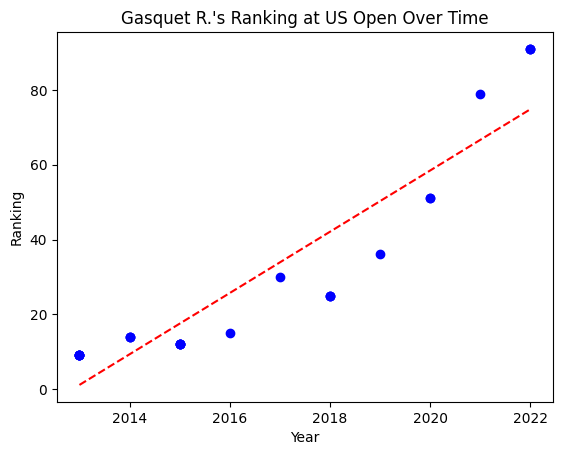

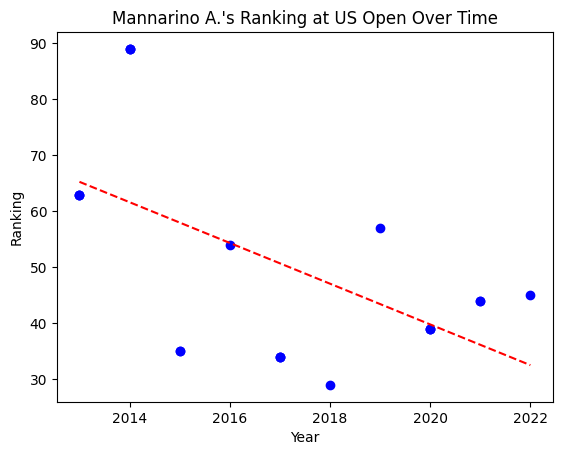

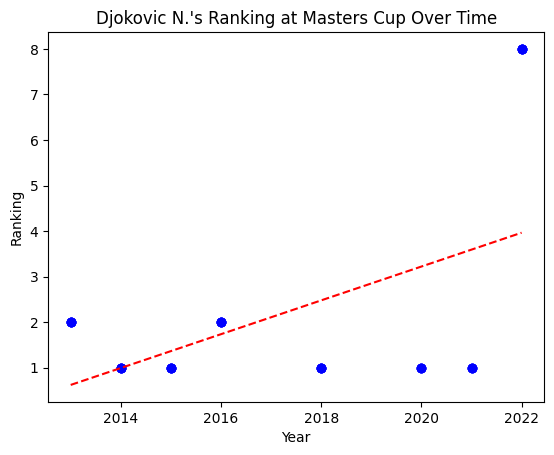

In [40]:
fig = plot_player_ranking_over_time('Gasquet R.', 'US Open')
plt.show()
fig = plot_player_ranking_over_time('Mannarino A.', 'US Open')
plt.show()
fig = plot_player_ranking_over_time('Djokovic N.', 'Masters Cup')
plt.show()

In [41]:
def win_rate_and_variance(player1_name, player2_name, tournament):
    """
    Calculates the win rates for two players and performs variance analysis
    (t-test) to determine if they're statistically significant.
    """
    # Loads dataset
    tennis_data = pd.read_csv("tennis_atp_3.csv")

    # Filters matches for specified tournament
    tournament_matches = tennis_data[tennis_data['Tournament'] == tournament]

    # Filters matches for the two players
    player1_matches = tournament_matches[(tournament_matches['Player_1'] == player1_name) |
                                        (tournament_matches['Player_2'] == player1_name)]
    
    player2_matches = tournament_matches[(tournament_matches['Player_1'] == player2_name) |
                                        (tournament_matches['Player_2'] == player2_name)]
    
    def calculate_win_rate(matches, player_name):
        """
        Calculates the win rate for a player given their matches.
        """
        win_count = (matches['Winner'] == player_name).sum()
        total_matches = len(matches)
        
        if total_matches > 0:
            win_rate = win_count / total_matches
        else:
            win_rate = 0
        
        return win_rate
    
    player1_win_rate = calculate_win_rate(player1_matches, player1_name)
    player2_win_rate = calculate_win_rate(player2_matches, player2_name)

    # Checks if both players never participated or have never won a match in specified tournament
    if player1_win_rate == 0.0:
        if player2_win_rate == 0.0:
            output = (
                f"Unable to perform variance analysis on win rates between "
                f"{player1_name} and {player2_name}.\n"
                f"Both players have either never played or never won a match at "
                f"{tournament}.\n\n"
            )
            return output
        
        # If not, check to see if JUST player1's win rate is nonexistent
        else:
            output = (
                f"Unable to perform variance analysis on win rates between "
                f"{player1_name} and {player2_name}.\n"
                f"{player1_name} has either never played or never won a match at "
                f"{tournament}.\n\n"
            )
            return output
        
    # If player1's win rate exists, checks if player2's win rate is nonexistent
    elif player2_win_rate == 0.0:
        output = (
            f"Unable to perform variance analysis on win rates between "
            f"{player1_name} and {player2_name}.\n"
            f"{player2_name} has either never played or never won a match at "
            f"{tournament}.\n\n"
        )
        return output
    
    # Create bootstrapped samples for t-test instead of using Boolean arrays directly
    player1_results = []
    for match in player1_matches.iterrows():
        win = 1 if match[1]['Winner'] == player1_name else 0
        player1_results.append(win)
        
    player2_results = []
    for match in player2_matches.iterrows():
        win = 1 if match[1]['Winner'] == player2_name else 0
        player2_results.append(win)
    
    # Performs variance analysis (t-test) to compare win rates
    t_statistic, p_value = ttest_ind(player1_results, player2_results)
    
    # Format the output string
    output = (
        f"{player1_name}'s Win Rate at {tournament}: {player1_win_rate}\n"
        f"{player2_name}'s Win Rate at {tournament}: {player2_win_rate}\n"
        f"T-Statistic: {t_statistic}\n"
        f"P-Value: {p_value}\n\n"
    )
    return output




#################### TESTS ####################
def test_win_rate_and_variance():
    # Test Case 1: Both players participated and have one at least one match in tournament
    expected_output = (
        "Djokovic N.'s Win Rate at Australian Open: 0.95\n"
        "Gasquet R.'s Win Rate at Australian Open: 0.631578947368421\n"
        "T-Statistic: 3.936292585453652\n"
        "P-Value: 0.0001801647466495753\n\n"
    )
    assert win_rate_and_variance('Djokovic N.', 'Gasquet R.', 'Australian Open') == expected_output
    
    # Test Case 2: One of the players never participated or have never one a match in tournament
    expected_output = (
        "Unable to perform variance analysis on win rates between Gasquet R. and Ito T..\n"
        "Ito T. has either never played or never won a match at Wimbledon.\n\n"
    )
    assert win_rate_and_variance('Gasquet R.', 'Ito T.', 'Wimbledon') == expected_output
    
    # Test Case 3: Both players never participated or have never one a match in tournament
    expected_output = (
        "Unable to perform variance analysis on win rates between De Voest R. and Ito T..\n"
        "Both players have either never played or never won a match at Wimbledon.\n\n"
    )
    assert win_rate_and_variance('De Voest R.', 'Ito T.', 'Wimbledon') == expected_output

# This should be at the same level as the function definition
test_win_rate_and_variance()

In [42]:
# statistically significant
print(win_rate_and_variance('Djokovic N.', 'Gasquet R.', 'Australian Open'))

# not statistically significant
print(win_rate_and_variance('Djokovic N.', 'Federer R.', 'Australian Open'))

# not statistically significant
print(win_rate_and_variance('Djokovic N.', 'Federer R.', 'Wimbledon'))

# statistically significant
print(win_rate_and_variance('Gasquet R.', 'Federer R.', 'Wimbledon'))

Djokovic N.'s Win Rate at Australian Open: 0.95
Gasquet R.'s Win Rate at Australian Open: 0.631578947368421
T-Statistic: 3.936292585453652
P-Value: 0.0001801647466495753


Djokovic N.'s Win Rate at Australian Open: 0.95
Federer R.'s Win Rate at Australian Open: 0.8636363636363636
T-Statistic: 1.5506342254834604
P-Value: 0.12408668356261715


Djokovic N.'s Win Rate at Wimbledon: 0.9473684210526315
Federer R.'s Win Rate at Wimbledon: 0.8478260869565217
T-Statistic: 1.7037111400970313
P-Value: 0.09151008184089804


Gasquet R.'s Win Rate at Wimbledon: 0.6363636363636364
Federer R.'s Win Rate at Wimbledon: 0.8478260869565217
T-Statistic: -1.9958969119667853
P-Value: 0.05007444224796607




In [43]:
def surface_performance_independence_test(player_name):
    """
    Performs Chi-squared test for independence to determine if a player's
    performance is significantly better on a particular surface.
    """
    # Loads dataset
    tennis_data = pd.read_csv("tennis_atp_3.csv")
    
    # Filters matches involving specified player
    player_1_matches = tennis_data['Player_1'] == player_name
    player_2_matches = tennis_data['Player_2'] == player_name
    
    player_matches = tennis_data[player_1_matches | player_2_matches]

    # Creates contingency table of surface type versus player's performance
    is_player_winner = player_matches['Winner'] == player_name
    contingency_table = pd.crosstab(player_matches['Surface'], is_player_winner)
    
    # Performs Chi-squared test for independence
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

    # Construct output string
    output = ""
    output += f"Is {player_name}'s performance significantly better on a particular surface?\n\n"
    output += "Chi-squared Statistic: " + str(chi2_stat) + "\n"
    output += "P-Value: " + str(p_value) + "\n"
    output += "Degrees of Freedom: " + str(dof) + "\n\n"

    return output




#################### TESTS ####################
def test_surface_performance_independence_test():
    
    # Test Case 1: A player's P-value is predicted to be statistically significant
    expected_output = (
        "Is Nadal R.'s performance significantly better on a particular surface?\n\n"
        "Chi-squared Statistic: 11.121600341228955\n"
        "P-Value: 0.003845697951640733\n"
        "Degrees of Freedom: 2\n\n"
    )
    assert surface_performance_independence_test('Nadal R.') == expected_output
    
    # Test Case 2: A player's P-value is predicted to be statistically insignificant
    expected_output = (
        "Is Monfils G.'s performance significantly better on a particular surface?\n\n"
        "Chi-squared Statistic: 4.3741013171273\n"
        "P-Value: 0.1122473165606904\n"
        "Degrees of Freedom: 2\n\n"
    )
    assert surface_performance_independence_test('Monfils G.') == expected_output
    
test_surface_performance_independence_test()

In [44]:
# Statistically significant, he's a clay god
print(surface_performance_independence_test('Nadal R.'))

# NOT statistically significant, he's just ok all around
print(surface_performance_independence_test('Gasquet R.'))

# Close to being statistically significant, but his win rate 
# on all surfaces is pretty good
print(surface_performance_independence_test('Djokovic N.'))

# Again CLOSE, he's all around good considering his title wins 
print(surface_performance_independence_test('Federer R.'))

Is Nadal R.'s performance significantly better on a particular surface?

Chi-squared Statistic: 11.121600341228955
P-Value: 0.003845697951640733
Degrees of Freedom: 2


Is Gasquet R.'s performance significantly better on a particular surface?

Chi-squared Statistic: 0.6930750030262466
P-Value: 0.7071323002587846
Degrees of Freedom: 2


Is Djokovic N.'s performance significantly better on a particular surface?

Chi-squared Statistic: 5.780624619701378
P-Value: 0.05555885832291923
Degrees of Freedom: 2


Is Federer R.'s performance significantly better on a particular surface?

Chi-squared Statistic: 5.907875198386635
P-Value: 0.052134018387857715
Degrees of Freedom: 2


